### traj_0120-0150_0006198242-325021_1

** packages **

In [1]:
from ctd2xray import cchdo
from mpl_toolkits.basemap import Basemap
from pymongo import MongoClient
import gsw
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

In [2]:
%matplotlib inline

** longitude **

In [3]:
# longitude range setting
# from -180 to 180
def format_180(longitude):
    if longitude < 180:
        longitude = longitude
    else:
        longitude = longitude - 360
    return longitude

In [4]:
format_180_v = np.vectorize(format_180)

In [5]:
# longitude range setting
# from 0 to 360
def format_360(longitude):
    if longitude < 180:
        longitude = longitude
    else:
        longitude = longitude + 360
    return longitude

In [6]:
format_360_v = np.vectorize(format_360)

** traj_0120-0150_0006198242 **

May 1, 1993 - May 31, 1993

In [7]:
rcs_eddies = MongoClient().eddies.rcs_eddies

In [8]:
eddy_code = 'traj_0120-0150_0006198242'

In [9]:
eddy_rclv = rcs_eddies.find_one({'_id': eddy_code})

In [12]:
eddy_area = eddy_rclv['area']

In [23]:
eddy_radius_meter = (eddy_area/np.pi)**0.5

In [24]:
eddy_radius_meter

36587.41025264148

In [25]:
earth_radius_meter = 6400000

In [26]:
eddy_radius_degree = 180*eddy_radi_meter/(np.pi*earth_radius_meter)

In [27]:
eddy_radius_degree

0.3275475298109428

In [29]:
eddy_traj = eddy_rclv['features'][2]['geometry']['coordinates']

In [30]:
obs_num = len(eddy_traj)

In [31]:
lon_eddy = np.zeros(obs_num)
lat_eddy = np.zeros(obs_num)

In [44]:
for i in range(obs_num):
    lon_eddy[i] = format_180(eddy_traj[i][0])
    lat_eddy[i] = eddy_traj[i][1]

In [69]:
lon_eddy_mean = lon_eddy.mean()
lat_eddy_mean = lat_eddy.mean()

** 325021_1 **

May 15, 1993 - Jun. 26, 1993

In [45]:
cchdo_ctd = MongoClient().eddies.cchdo_ctd

In [46]:
expo_code = '325021_1'

In [47]:
cas_num = cchdo_ctd.find({'expocode': expo_code}).count()

In [48]:
lon_expo = np.zeros(cas_num)
lat_expo = np.zeros(cas_num)

In [49]:
i = 0
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    lon_expo[i] = expo['location']['coordinates'][0]
    lat_expo[i] = expo['location']['coordinates'][1]
    i = i+1

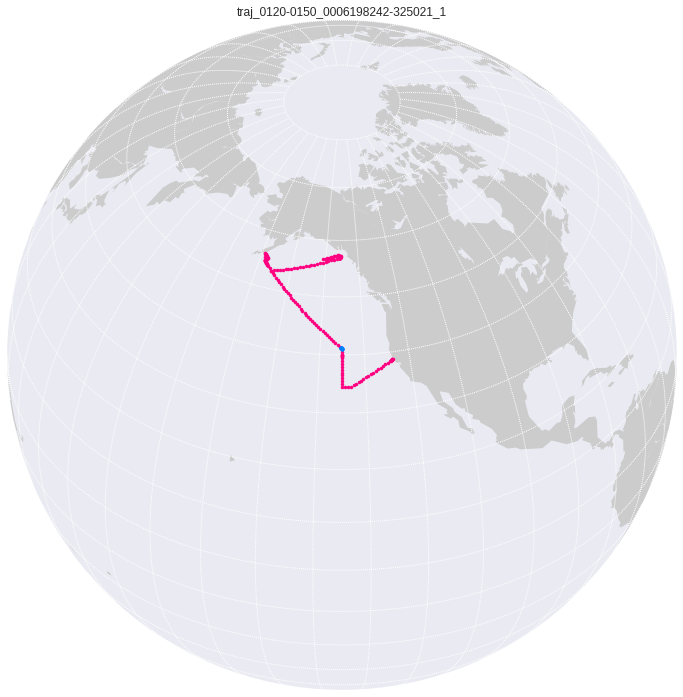

In [50]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(projection='ortho', lon_0=225, lat_0=40, resolution='c')
my_map.drawmapboundary(linewidth=0)
my_map.drawparallels(np.arange(-90, 90, 10), color='w')
my_map.drawmeridians(np.arange(0, 360, 10), color='w')
my_map.fillcontinents()
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff', zorder=20)
my_map.plot(x_expo, y_expo, '.', color='#ff0080', zorder=10)
plt.title(eddy_code + '-' + expo_code)
plt.savefig('figures/figure-0/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

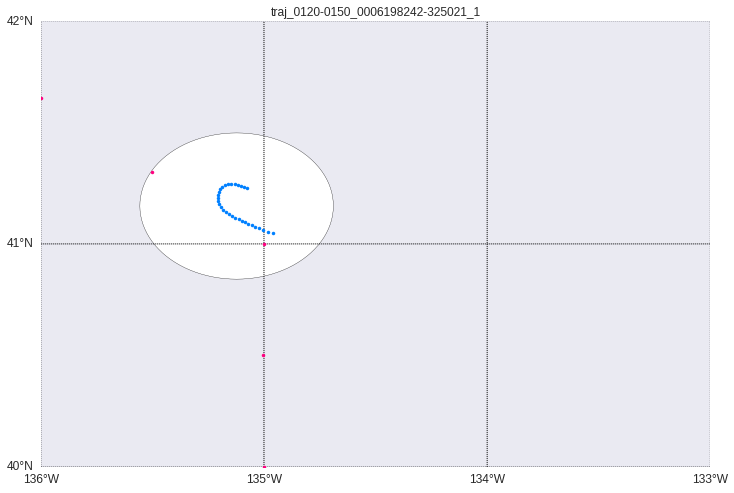

In [72]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(projection='cyl', llcrnrlat=40, urcrnrlat=42,\
                 llcrnrlon=-136, urcrnrlon=-133, resolution='c')
my_map.tissot(lon_0=lon_eddy_mean, lat_0=lat_eddy_mean, radius_deg=eddy_radius_degree,\
              npts=100, facecolor='white', zorder=1)
my_map.fillcontinents()
my_map.drawparallels(np.arange(-90, 90, 1), labels=[True,False,False,True])
my_map.drawmeridians(np.arange(0, 360, 1), labels=[True,False,False,True])
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff')
my_map.plot(x_expo, y_expo, '.', color='#ff0080')
plt.title(eddy_code + '-' + expo_code)
plt.savefig('figures/figure-1/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** temperature-salinity **

In [ ]:
STA = 46
CAS = 1

In [ ]:
sns.set(color_codes=True)
mpl.rcParams['font.family'] = "STIX"
mpl.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    woce = str(ds.WOCE_ID)
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (station == STA and cast == CAS):
        DAT = time
        LAT = lat
        plt.plot(sa, ct, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(sa, ct, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(sa, ct, color='#999999', zorder=1)
plt.xlim([32.5, 35])
plt.ylim([0, 10])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('salinity')
plt.ylabel('temperature')
plt.savefig('figures/figure-2/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** pressure-temperature **

In [ ]:
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    woce = str(ds.WOCE_ID)
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (station == STA and cast == CAS):
        LAT = lat
        plt.plot(ct, p, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(ct, p, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(ct, p, color='#999999', zorder=1)
plt.xlim([0, 10])
plt.ylim([1000, 0])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('temperature')
plt.ylabel('pressure')
plt.savefig('figures/figure-3/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** pressure-salinity **

In [ ]:
sns.set(color_codes=True)
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    time = ds.time.values[0]
    woce = str(ds.WOCE_ID)
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (station == STA and cast == CAS):
        DAT = time
        LAT = lat
        plt.plot(sa, p, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(sa, p, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(sa, p, color='#999999', zorder=1)
plt.xlim([32.5, 35])
plt.ylim([1000, 0])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('salinity')
plt.ylabel('pressure')
plt.savefig('figures/figure-4/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** pressure-oxygen **

In [ ]:
sns.set(color_codes=True)
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['font.family'] = "STIX"
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    woce = str(ds.WOCE_ID)
    time = ds.time.values[0]
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.salinity.values
    o = ds.oxygen.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = int(filter(str.isdigit, str(ds.STATION_NUMBER)))
    cast = int(filter(str.isdigit, str(ds.CAST_NUMBER)))
    if (station == STA and cast == CAS):
        LAT = lat
        plt.plot(o, p, color='#ff0000', zorder=2)
    elif (STA-6) < station < STA:
        plt.plot(o, p, color='#cccccc', zorder=1)
    elif STA < station < (STA+6):
        plt.plot(o, p, color='#999999', zorder=1)
plt.xlim([0, 350])
plt.ylim([1000, 0])
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('oxygen')
plt.ylabel('pressure')
plt.savefig('figures/figure-5/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** contours **

In [ ]:
path_list = '/home/cz2397/data/cchdo-ctd/327_p17n_nc_ctd/p17n*'

In [ ]:
pressure = np.linspace(0, 6000, num=6001, endpoint=True)

In [ ]:
ds_tim = cchdo.open_cchdo_as_mfdataset(path_list, pressure)

In [ ]:
ds_lat = ds_tim.swap_dims({'time': 'latitude'})

In [ ]:
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(16, 8))
mpl.rcParams['font.family'] = "STIX"
image = ds_lat.temperature_i.T.plot.contourf(yincrease=False, ax=ax, cmap='bwr',\
                                             vmin=2, vmax=6, levels=40)
image.colorbar.set_label('temperature')
plt.xlim([LAT-5, LAT+5])
plt.ylim([1000, 0])
plt.axvline(LAT, color='k')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('latitude')
plt.ylabel('pressure')
plt.savefig('figures/figure-6/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

In [ ]:
mpl.rcParams['font.family'] = 'STIX'
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(color_codes=True)
image = ds_lat.salinity_i.T.plot.contourf(yincrease=False, ax=ax, cmap='bwr',\
                                          vmin=32.5, vmax=35, levels=40)
image.colorbar.set_label('salinity')
plt.xlim([LAT-5, LAT+5])
plt.ylim([1000, 0])
plt.axvline(LAT, color='k')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('latitude')
plt.ylabel('pressure')
plt.savefig('figures/figure-7/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

In [ ]:
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(16, 8))
mpl.rcParams['font.family'] = "STIX"
image = ds_lat.oxygen_i.T.plot.contourf(yincrease=False, ax=ax, cmap='bwr',\
                                        vmin=20, vmax=300, levels=45)
image.colorbar.set_label('oxygen')
plt.xlim([LAT-5, LAT+5])
plt.ylim([1000, 0])
plt.axvline(LAT, color='k')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('latitude')
plt.ylabel('pressure')
plt.savefig('figures/figure-8/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()